In [1]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torchvision


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.2 MB 17.6 MB/s eta 0:00:01B 17.6 MB/s eta 0:00:01
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [3]:
Transform =  transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])
trainingdata = torchvision.datasets.CIFAR10(root='./ data', train=True, download=True, transform=Transform) 
testdata = torchvision.datasets.CIFAR10(root='./data',  train=False, download=True, transform=Transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainDataLoader = DataLoader(trainingdata, batch_size= 64, shuffle=True)
testDataLoader = DataLoader(testdata, batch_size= 64, shuffle=False)

In [8]:
model=project1_model()
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    model.cuda()

In [13]:
train_loss_history = []
test_loss_history = []
train_acc_history = [] 
test_acc_history = [] 


for epoch in range(25):
    train_loss = 0.0
    test_loss = 0.0
    correct_points_train = 0 
    correct_points_test = 0 
    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        predicted_output = model(images)
        fit = Loss(predicted_output,labels)
        optimizer.zero_grad()
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        correct_points_train +=  (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()).data.cpu().numpy()
    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            correct_points_test +=  (torch.eq(torch.max(predicted_output, 1) [1],labels).sum()).data.cpu().numpy() 
            
    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    
    train_acc = correct_points_train/len(trainDataLoader) 
    test_acc = correct_points_test/len(testDataLoader) 
    
    train_acc_history.append(train_acc) 
    test_acc_history.append(test_acc)

    print('Epoch %s, Train loss %s, Test loss %s Train accuracy %s Test accuracy  %s'%(epoch, train_loss, test_loss, train_acc, test_acc))
    #print("Accuracy:", (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()/len(labels)*100).data.cpu().numpy())

Epoch 0, Train loss 0.31696353921347564, Test loss 0.4322978141391353 Train accuracy 56.90281329923274 Test accuracy  54.24203821656051
Epoch 1, Train loss 0.29040780549159134, Test loss 0.41470552069746003 Train accuracy 57.48849104859335 Test accuracy  54.92993630573248
Epoch 2, Train loss 0.28228718980841927, Test loss 0.4053190400835815 Train accuracy 57.63427109974425 Test accuracy  55.0
Epoch 3, Train loss 0.26467034901918657, Test loss 0.4120910758045828 Train accuracy 58.01662404092072 Test accuracy  54.97452229299363
Epoch 4, Train loss 0.2515747533334643, Test loss 0.39744728291110626 Train accuracy 58.41943734015345 Test accuracy  55.10828025477707
Epoch 5, Train loss 0.23362368424339672, Test loss 0.38353143713087035 Train accuracy 58.705882352941174 Test accuracy  55.78343949044586
Epoch 6, Train loss 0.227634668107266, Test loss 0.40026993081448187 Train accuracy 58.84398976982097 Test accuracy  55.17197452229299
Epoch 7, Train loss 0.21662105924790473, Test loss 0.368415

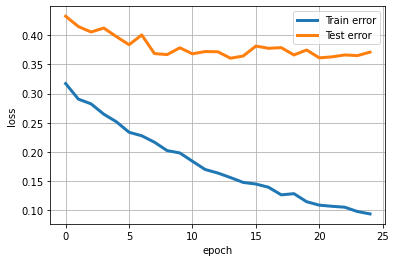

In [14]:
#import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(25),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(25),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()